# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal/
!ls

In [ ]:
! pwd

# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys
import os
import copy
import math

import importlib

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from astropy.io  import fits
from astropy     import units as u
from astropy.wcs import WCS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from spectral_cube import SpectralCube
from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct101_checkpoint_path = checkpoint_path / 'c101'
ct256_checkpoint_path = checkpoint_path / 'c256_1split'
cnn101_checkpoint_path = checkpoint_path / 'cnn' / 'c101'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'

saury2014_data_path = data_path / 'saury'
seta222_data_path = data_path / 'seta'

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)
    c = SpectralCube.read(dat)

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]

    dat.close()

    print(f"Cube shape: {c.shape}") # (vlsr, b, l)

    del dat

    _, _, x = c.world[0, 0, :]    # extract RA: deg
    _, y, _ = c.world[0, :, 0]    # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

In [ ]:
def m2fwhm(cube):
    #Velocity range and channel spacing
    vmin = -40 #km.s-1
    vmax = 40 #km.s-1

    dv = 0.3125 # 0.15625 # 0.8 #km.s-1
    # v = np.arange(vmin, vmax+dv, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
    v = np.arange(vmin, vmax, dv)

    # Calculate the moments
    # Compute Moment 0
    moment0 = np.sum(cube, axis=0) * dv

    # Compute Moment 1
    moment1 = np.sum(cube * v[:, None, None], axis=0) * dv / moment0

    # Compute Moment 2
    vdiff_squared = (v[:, None, None] - moment1)**2
    moment2 = np.sum(cube * vdiff_squared, axis=0) * dv / moment0

    sigma_m2 = np.sqrt(moment2)
    FWHM = sigma_m2 * np.sqrt(8.*np.log(2))
    return FWHM

# Read data

In [ ]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x nchan)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'

training_data_file_q0 = os.path.join(saury2014_data_path, training_data_file_q0)
training_data_file_q1 = os.path.join(saury2014_data_path, training_data_file_q1)
training_data_file_q2 = os.path.join(saury2014_data_path, training_data_file_q2)
training_data_file_q3 = os.path.join(saury2014_data_path, training_data_file_q3)

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_2.fits'

rhi_file_q0 = os.path.join(saury2014_data_path, rhi_file_q0)
rhi_file_q1 = os.path.join(saury2014_data_path, rhi_file_q1)
rhi_file_q2 = os.path.join(saury2014_data_path, rhi_file_q2)
rhi_file_q3 = os.path.join(saury2014_data_path, rhi_file_q3)

# 3a. FCNM maps
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3.fits'

fcnm_file_q0 = os.path.join(saury2014_data_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(saury2014_data_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(saury2014_data_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(saury2014_data_path, fcnm_file_q3)

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

# Spectal res: 1.0 km/s
# Channel spacing: 0.824 km/s

In [ ]:
training_data_file_q4 = 'Tb_mpism_sol_800_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q4 = seta222_data_path / training_data_file_q4

tau_data_file_q4 = 'tau_mpism_sol_800_turb_thick_256chan_noise.fits'
tau_data_file_q4 = seta222_data_path / tau_data_file_q4

rhi_file_q4 = 'rhi_map_mpism_sol_800_Tcut_500K_thick_101chan.fits'
rhi_file_q4 = seta222_data_path / rhi_file_q4

fcnm_file_q4 = 'fcnm_map_mpism_sol_800_Tcut_500K.fits'
fcnm_file_q4 = seta222_data_path / fcnm_file_q4

# Read all cubes at once

In [ ]:
nlen = 512*512*3
nclen = 512*512

In [ ]:
NHI_flat = np.zeros(nlen)
FWHM_flat = np.zeros(nlen)
FCNM_flat = np.zeros(nlen)
RHI_flat = np.zeros(nlen)

In [ ]:
cfiles = [training_data_file_q0, training_data_file_q1, training_data_file_q2, training_data_file_q4]
ffiles = [fcnm_file_q0, fcnm_file_q1, fcnm_file_q2, fcnm_file_q4]
rfiles = [rhi_file_q0, rhi_file_q1, rhi_file_q2, rhi_file_q4]


cfiles = [training_data_file_q0, training_data_file_q3, training_data_file_q4]
ffiles = [fcnm_file_q0, fcnm_file_q3, fcnm_file_q4]
rfiles = [rhi_file_q0, rhi_file_q3, rhi_file_q4]
for i in range(3):
  print(cfiles[i], ffiles[i], rfiles[i]) # tfiles[i],

  cube, header1 = fits.getdata(cfiles[i], header=True)
  fcnm_data, header1 = fits.getdata(ffiles[i], header=True)
  rhi_data, header1 = fits.getdata(rfiles[i], header=True)

  # TB max
  tbmax_map = np.max(cube, axis=0)
  tbmax_flat = tbmax_map.flatten()

  fwhm_m2 = m2fwhm(cube)

  FCNM_flat[i*nclen : (i+1)*nclen] = fcnm_data.flatten()
  RHI_flat[i*nclen : (i+1)*nclen] = rhi_data.flatten()
  FWHM_flat[i*nclen : (i+1)*nclen] = fwhm_m2.flatten()

In [ ]:
FCNM_flat = np.nan_to_num(FCNM_flat, 0.)
RHI_flat = np.nan_to_num(RHI_flat, 0.)
FWHM_flat = np.nan_to_num(FWHM_flat, 0.)

In [ ]:
import scipy.stats
print('fcnm vs rhi:', scipy.stats.pearsonr(FCNM_flat, RHI_flat))    # Pearson's r
print('FWHM vs rhi:', scipy.stats.pearsonr(FWHM_flat, RHI_flat))    # Pearson's r
print('Fcnm vs FWHM:', scipy.stats.pearsonr(FCNM_flat, FWHM_flat))    # Pearson's r

fcnm vs rhi: PearsonRResult(statistic=0.30281228951552447, pvalue=0.0)
FWHM vs rhi: PearsonRResult(statistic=-0.05789822893731514, pvalue=0.0)
Fcnm vs FWHM: PearsonRResult(statistic=-0.07759454399718928, pvalue=0.0)


In [ ]:
import scipy.stats
print('fcnm vs rhi:', scipy.stats.spearmanr(FCNM_flat, RHI_flat))    # spearmanr's r
print('FWHM vs rhi:', scipy.stats.spearmanr(FWHM_flat, RHI_flat))    # spearmanr's r
print('Fcnm vs FWHM:', scipy.stats.spearmanr(FCNM_flat, FWHM_flat))    # spearmanr's r

fcnm vs rhi: SignificanceResult(statistic=0.6953401319218017, pvalue=0.0)
FWHM vs rhi: SignificanceResult(statistic=-0.016465365698908933, pvalue=2.7026521196613376e-48)
Fcnm vs FWHM: SignificanceResult(statistic=-0.10570010294695617, pvalue=0.0)


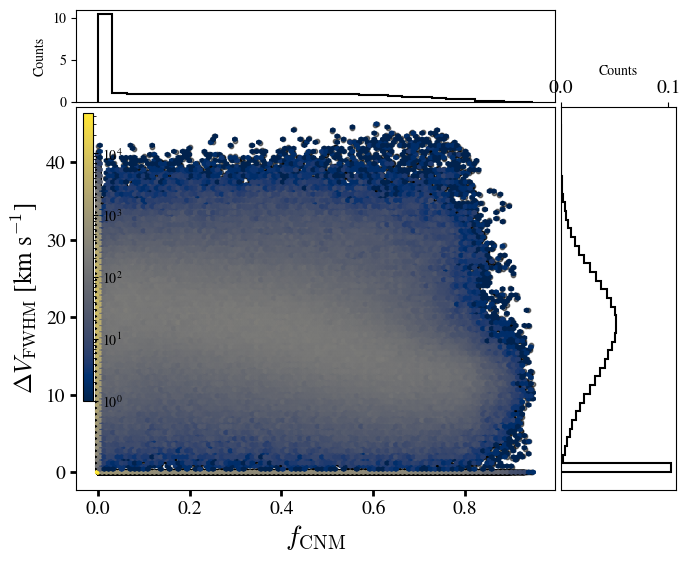

In [ ]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:5, :4])
ax_xDist = plt.subplot(gs[0, :4],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:5, 4],sharey=ax_main)

# set the distance between the main plot and marginal plots
fig.subplots_adjust(bottom=0.2, left=0.2, right=0.8, top=0.8, wspace=0.05, hspace=0.05)

sct = ax_main.scatter(FCNM_flat, FWHM_flat,
                   zorder=1, s=10,
                   alpha=0.5,
                   marker='o', c='k', # vmin=0., vmax=37.,
                   label='')

img = ax_main.hexbin(FCNM_flat, FWHM_flat, gridsize=100, cmap='cividis', norm=LogNorm())

axins1 = inset_axes(ax_main,
                    width="2%",  # width: 50% of parent_bbox width
                    height="75%",  # height: 5%
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=9)


ax_main.set_ylabel(r'$\Delta V_\mathrm{FWHM}$ [km s$^{-1}$]', fontsize=18)
ax_main.set_xlabel(r'${f_\mathrm{CNM}}$', fontsize=20, fontweight='normal')

ax_main.tick_params(axis='x', labelsize=14, pad=4)
ax_main.tick_params(axis='y', labelsize=14)
ax_main.tick_params(which='both', width=2)
ax_main.tick_params(which='major', length=4)
ax_main.tick_params(which='minor', length=2)
ax_main.grid(False)


# Top
cnts, bins, _ = ax_xDist.hist(FCNM_flat,
                              bins=30,
                              density=True,
                              color='k',
                              histtype='step',
                              align='mid',
                              alpha=1.,
                              ls='-',
                              lw=1.5
                              )
ax_xDist.set(ylabel='Counts')

# Right
cnts, bins, _ = ax_yDist.hist(FWHM_flat,
                                bins=40,
                                density=True,
                                color='k',
                                histtype='step',
                                align='mid',
                                alpha=1.,
                                ls='-',
                                lw=1.5,
                                orientation='horizontal'
                                )
ax_yDist.xaxis.set_label_position('top')
ax_yDist.xaxis.tick_top()
ax_yDist.tick_params(axis='x', labeltop=True)
ax_yDist.tick_params(axis='x', labelsize=14)
ax_yDist.set(xlabel='Counts')

# Turn off tick labels on marginals
ax_xDist.axes.xaxis.set_visible(False)
ax_yDist.axes.yaxis.set_visible(False)


plt.show()

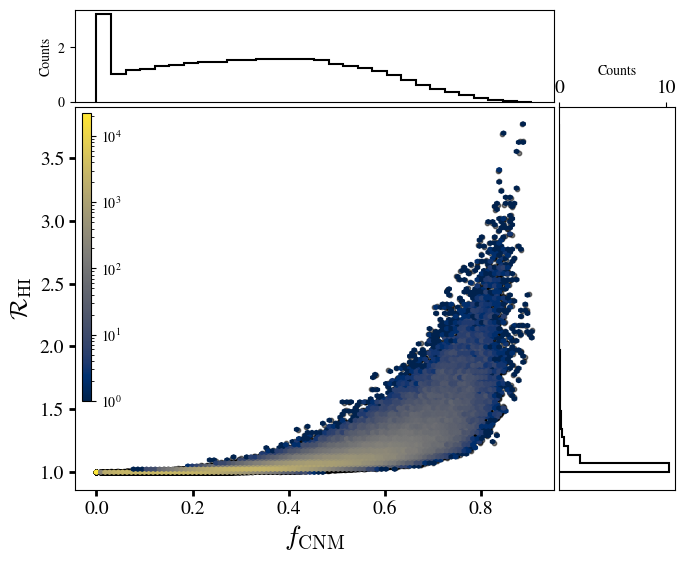

In [ ]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:5, :4])
ax_xDist = plt.subplot(gs[0, :4],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:5, 4],sharey=ax_main)

# set the distance between the main plot and marginal plots
fig.subplots_adjust(bottom=0.2, left=0.2, right=0.8, top=0.8, wspace=0.05, hspace=0.05)


sct = ax_main.scatter(Fcnm_gt_flat, Rhi_gt_flat,
                   zorder=1, s=10,
                   alpha=0.5,
                   marker='o', c='k',
                   label='')



img = ax_main.hexbin(Fcnm_gt_flat, Rhi_gt_flat, gridsize=100, cmap='cividis', norm=LogNorm())


axins1 = inset_axes(ax_main,
                    width="2%",
                    height="75%",
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=9)

ax_main.set_ylabel(r'${\mathcal{R}_\mathrm{HI}}$', fontsize=18)
ax_main.set_xlabel(r'${f_\mathrm{CNM}}$', fontsize=20, fontweight='normal')

ax_main.tick_params(axis='x', labelsize=14, pad=4)
ax_main.tick_params(axis='y', labelsize=14)
ax_main.tick_params(which='both', width=2)
ax_main.tick_params(which='major', length=4)
ax_main.tick_params(which='minor', length=2)
ax_main.grid(False)


# Top
cnts, bins, _ = ax_xDist.hist(Fcnm_gt_flat,
                              bins=30,
                              density=True,
                              color='k',
                              histtype='step',
                              align='mid',
                              alpha=1.,
                              ls='-',
                              lw=1.5
                              )
ax_xDist.set(ylabel='Counts')

# Right
cnts, bins, _ = ax_yDist.hist(Rhi_gt_flat,
                                bins=40,
                                density=True,
                                color='k',
                                histtype='step',
                                align='mid',
                                alpha=1.,
                                ls='-',
                                lw=1.5,
                                orientation='horizontal'
                                )
ax_yDist.xaxis.set_label_position('top')
ax_yDist.xaxis.tick_top()
ax_yDist.tick_params(axis='x', labeltop=True)
ax_yDist.tick_params(axis='x', labelsize=14)
ax_yDist.set(xlabel='Counts')

# Turn off tick labels on marginals
ax_xDist.axes.xaxis.set_visible(False)
ax_yDist.axes.yaxis.set_visible(False)

plt.show()

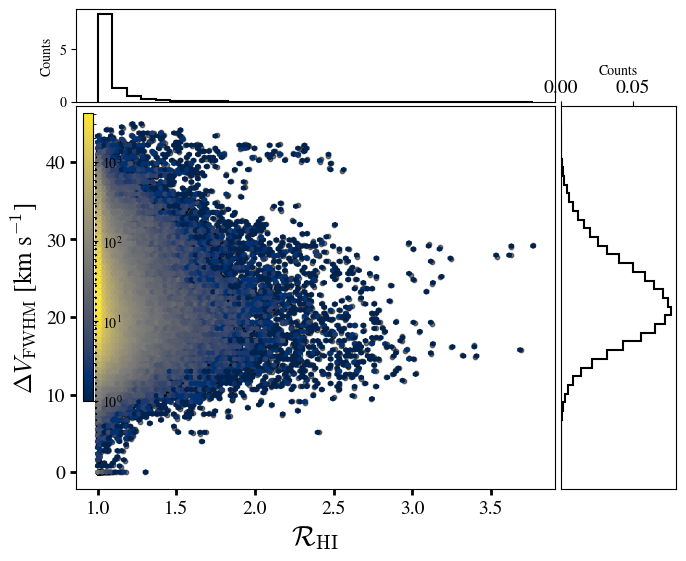

In [ ]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:5, :4])
ax_xDist = plt.subplot(gs[0, :4],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:5, 4],sharey=ax_main)

# set the distance between the main plot and marginal plots
fig.subplots_adjust(bottom=0.2, left=0.2, right=0.8, top=0.8, wspace=0.05, hspace=0.05)

sct = ax_main.scatter(Rhi_gt_flat, FWHM_flat,
                   zorder=1, s=10,
                   alpha=0.5,
                   marker='o', c='k',
                   label='')


img = ax_main.hexbin(Rhi_gt_flat, FWHM_flat, gridsize=100, cmap='cividis', norm=LogNorm())

axins1 = inset_axes(ax_main,
                    width="2%",
                    height="75%",
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('', rotation=90, labelpad=5., fontsize=9)

ax_main.set_ylabel(r'$\Delta V_\mathrm{FWHM}$ [km s$^{-1}$]', fontsize=18)
ax_main.set_xlabel(r'${\mathcal{R}_\mathrm{HI}}$', fontsize=20, fontweight='normal')

ax_main.tick_params(axis='x', labelsize=14, pad=4)
ax_main.tick_params(axis='y', labelsize=14)
ax_main.tick_params(which='both', width=2)
ax_main.tick_params(which='major', length=4)
ax_main.tick_params(which='minor', length=2)
ax_main.grid(False)


# Top
cnts, bins, _ = ax_xDist.hist(Rhi_gt_flat,
                              bins=30,
                              density=True,
                              color='k',
                              histtype='step',
                              align='mid',
                              alpha=1.,
                              ls='-',
                              lw=1.5
                              )
ax_xDist.set(ylabel='Counts')

# Right
cnts, bins, _ = ax_yDist.hist(FWHM_flat,
                                bins=40,
                                density=True,
                                color='k',
                                histtype='step',
                                align='mid',
                                alpha=1.,
                                ls='-',
                                lw=1.5,
                                orientation='horizontal'
                                )
ax_yDist.xaxis.set_label_position('top')
ax_yDist.xaxis.tick_top()
ax_yDist.tick_params(axis='x', labeltop=True)
ax_yDist.tick_params(axis='x', labelsize=14)
ax_yDist.set(xlabel='Counts')

# Turn off tick labels on marginals
ax_xDist.axes.xaxis.set_visible(False)
ax_yDist.axes.yaxis.set_visible(False)

plt.show()